In [585]:
import os
import time

import numpy as np

import igraph
from igraph import Graph

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from tqdm import tqdm
from scipy.stats import pearsonr
from graphviz import Digraph
import scipy

import matplotlib.pyplot as plt

nasbench201 = torch.load('/home/rob/Git/meta-fsl-nas/metanas/metanas/meta_predictor/data/nasbench201.pt')

## Make input iGraph for meta-predictor

In [604]:
PRIMITIVES_FEWSHOT = [
    "max_pool_3x3",
    "avg_pool_3x3",
    "skip_connect",  # identity
    "conv_1x5_5x1",
    "conv_3x3",
    "sep_conv_3x3",
    # "sep_conv_5x5",  # remove
    "dil_conv_3x3",
    # "dil_conv_5x5",  # remove
    # "none",  # remove
]


PRIMITIVES_NAS_BENCH_201 = [
    'none',
    'skip_connect',
    'nor_conv_1x1',
    'nor_conv_3x3',
    'avg_pool_3x3'
]

n_nodes = 3
n_ops = len(PRIMITIVES_NAS_BENCH_201)

alpha_normal = []

for i in range(n_nodes):
    alpha_normal.append(nn.Parameter(
        1e-3 * torch.randn(i + 2, n_ops)* 0.5 + 1))

def parse(alpha, k, primitives=PRIMITIVES_NAS_BENCH_201):
    gene = []
    for edges in alpha:
        edge_max, primitive_indices = torch.topk(
            edges[:, :], 1
        )
        print(edge_max.view(-1))
        
        topk_edge_values, topk_edge_indices = torch.topk(edge_max.view(-1), k)
        
        print("top_k")
        print(topk_edge_values)
        print(topk_edge_indices, "\n")
        
        node_gene = []
        for edge_idx in topk_edge_indices:
            prim_idx = primitive_indices[edge_idx]
            prim = primitives[prim_idx]
            node_gene.append((prim, edge_idx.item()))

        gene.append(node_gene)
    return gene

geno = parse(alpha_normal, k=2)
geno

tensor([1.0007, 1.0008], grad_fn=<ViewBackward>)
top_k
tensor([1.0008, 1.0007], grad_fn=<TopkBackward>)
tensor([1, 0]) 

tensor([1.0005, 1.0002, 1.0008], grad_fn=<ViewBackward>)
top_k
tensor([1.0008, 1.0005], grad_fn=<TopkBackward>)
tensor([2, 0]) 

tensor([1.0004, 1.0005, 1.0006, 1.0008], grad_fn=<ViewBackward>)
top_k
tensor([1.0008, 1.0006], grad_fn=<TopkBackward>)
tensor([3, 2]) 



[[('nor_conv_3x3', 1), ('nor_conv_3x3', 0)],
 [('nor_conv_1x1', 2), ('nor_conv_1x1', 0)],
 [('nor_conv_1x1', 3), ('nor_conv_3x3', 2)]]

In [607]:

# PRIMITIVES_NAS_BENCH_201


['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']

0 [('nor_conv_3x3', 1), ('nor_conv_3x3', 0)]
3 1
3 0
1 [('nor_conv_1x1', 2), ('nor_conv_1x1', 0)]
2 2
2 0
2 [('nor_conv_1x1', 3), ('nor_conv_3x3', 2)]
2 3
3 2


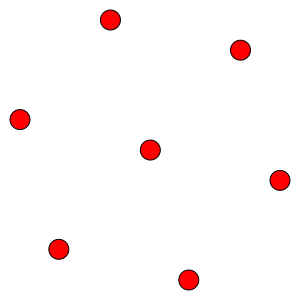

In [613]:
# the 2, original input nodes
# TODO: Should be plus 2


primitives = PRIMITIVES_NAS_BENCH_201
n_edges = sum([len(x) for x in geno])
n = len(geno) + 4 # start, end node

g = Graph(directed=True)
g.add_vertices(n)

for i, node in enumerate(geno):
    print(i, node)
    
    for j, edge in enumerate(node):
        edge_op, edge_in = edge
        edge_op = primitives.index(edge_op)
        
        
        print(edge_op, edge_in)
# for i, edges in enumerate(alpha_normal):
# #     print(f"node {i}")
#     g.vs[i]['label'] = i
#     for j, edge in enumerate(edges):
# #         print(j, i+2)
#         g.add_edges([(j, i+2)])
        
        
ig.plot(g, bbox=(0, 0, 300, 300))

In [612]:
for i in geno:
    print(i)
    
n_edges

[('nor_conv_3x3', 1), ('nor_conv_3x3', 0)]
[('nor_conv_1x1', 2), ('nor_conv_1x1', 0)]
[('nor_conv_1x1', 3), ('nor_conv_3x3', 2)]


6

In [620]:
# Limit to 6 inputs?

n_edges = sum([len(x) for x in geno])
edges = [0]

for node in geno:
    for op, _ in node:
        # plus two, to not confuse the 
        # start node and end node
        op = primitives.index(op) + 2
        edges.append(op)
        
edges.append(1)
edges

[0, 5, 5, 4, 4, 4, 5, 1]

In [ ]:
# 2 more input nodes than original

m = [[0],       # Added input node
#      [3, 1],    # Input node 1, skip-conn (DARTS)
#      [3, 1, 0], # Input node 2, skip-conn (DARTS)
     [5, 1]
     [5, 1, 0]
     [4, 0, 1, 0]
     [4, 1, 0, 0, 0]
     [4, 0, 1, 0, 0, 0]
     [5, 0, 0, 1, 1, 0, 0]
     [1, 0, 0, 0, 0, 1, 1, 1]]

In [ ]:
primitives = PRIMITIVES_NAS_BENCH_201
n_edges = sum([len(x) for x in geno])
n = len(geno) + 4 # start, end node

g = Graph(directed=True)
g.add_vertices(n)

for i, node in enumerate(geno):
    print(i, node)
    
    for j, edge in enumerate(node):
        edge_op, edge_in = edge
        edge_op = primitives.index(edge_op)
        
        
        print(edge_op, edge_in)
# for i, edges in enumerate(alpha_normal):
# #     print(f"node {i}")
#     g.vs[i]['label'] = i
#     for j, edge in enumerate(edges):
# #         print(j, i+2)
#         g.add_edges([(j, i+2)])
        
        
ig.plot(g, bbox=(0, 0, 300, 300))

In [626]:

from graphviz import Digraph

def plot(genotype, file_path, caption=None):
    """ make DAG plot and save to file_path as .png """
    edge_attr = {"fontsize": "20", "fontname": "times"}
    node_attr = {
        "style": "filled",
        "shape": "rect",
        "align": "center",
        "fontsize": "20",
        "height": "0.5",
        "width": "0.5",
        "penwidth": "2",
        "fontname": "times",
    }
    g = Digraph(format="png", edge_attr=edge_attr, node_attr=node_attr, engine="dot")
    g.body.extend(["rankdir=LR"])

    # input nodes
    g.node("c_{k-2}", fillcolor="darkseagreen2")
    g.node("c_{k-1}", fillcolor="darkseagreen2")

    # intermediate nodes
    n_nodes = len(genotype)
    for i in range(n_nodes):
        g.node(str(i), fillcolor="lightblue")

    for i, edges in enumerate(genotype):
        for op, j in edges:
            if j == 0:
                u = "c_{k-2}"
            elif j == 1:
                u = "c_{k-1}"
            else:
                u = str(j - 2)

            v = str(i)
            g.edge(u, v, label=op, fillcolor="gray")

    # output node
    g.node("c_{k}", fillcolor="palegoldenrod")
    for i in range(n_nodes):
        g.edge(str(i), "c_{k}", fillcolor="gray")

    # add image caption
    if caption:
        g.attr(label=caption, overlap="false", fontsize="20", fontname="times")

    g.render(file_path, view=False)
    
plot(geno, "/home/rob/Git/meta-fsl-nas/notebooks/normal.png")